In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#Install dependencies
!pip install torchcfm

!pip install torch>=1.11.0
!pip install torchvision>=0.11.0

!pip install lightning-bolts
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install scikit-learn
!pip install scprep
!pip install scanpy
!pip install torchdyn>=1.0.6
!pip install pot
!pip install torchdiffeq
!pip install absl-py
!pip install clean-fid


In [ ]:
%load_ext autoreload
%autoreload 2
import os

import matplotlib.pyplot as plt
import torch
import torchsde
from torchdyn.core import NeuralODE
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from tqdm import tqdm

from torchcfm.conditional_flow_matching import *
from torchcfm.models.unet import UNetModel

savedir = "models/mnist"
os.makedirs(savedir, exist_ok=True)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

batch_size = 128
n_epochs = 5

trainset = datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]),
)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, drop_last=True
)

In [ ]:
###########################################
#  Train score score and deterministic flow
###########################################
sigma = 0.1

#Deterministic flow model
model = UNetModel(dim=(1, 28, 28), num_channels=32, num_res_blocks=1).to(device)

#Score model
score_model = UNetModel(dim=(1, 28, 28), num_channels=32, num_res_blocks=1).to(device)

optimizer = torch.optim.Adam(list(model.parameters()) + list(score_model.parameters()))
FM = ConditionalFlowMatcher(sigma=sigma)
node = NeuralODE(model, solver="euler", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [ ]:
for epoch in range(n_epochs):
    for i, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        x1 = data[0].to(device)
        x0 = torch.randn_like(x1)
        t, xt, ut, eps = FM.sample_location_and_conditional_flow(x0, x1, return_noise=True)
        lambda_t = FM.compute_lambda(t)
        vt = model(t, xt)
        st = score_model(t, xt)

        flow_loss = torch.mean((vt - ut) ** 2)
        score_loss = torch.mean((lambda_t * st - eps) ** 2)

        loss = flow_loss + score_loss
        loss.backward()
        optimizer.step()

468it [00:50,  9.34it/s]
468it [00:50,  9.35it/s]
468it [00:50,  9.36it/s]
468it [00:49,  9.37it/s]
468it [00:49,  9.38it/s]


In [ ]:
#Save trained models
torch.save(score_model,'/content/drive/MyDrive/score_model_10epochs.pt')
torch.save(model, '/content/drive/MyDrive/flow_model_10epochs.pt')

In [ ]:
#Random initial condition sampled from standard Gaussian
initial_condition = torch.randn(100, 1, 28, 28).to(device)

/usr/local/lib/python3.10/dist-packages/torchdyn/numerics/odeint.py:83: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


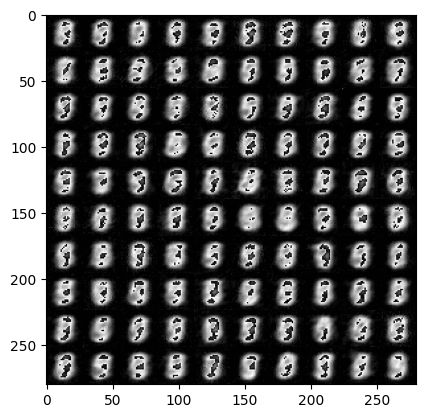

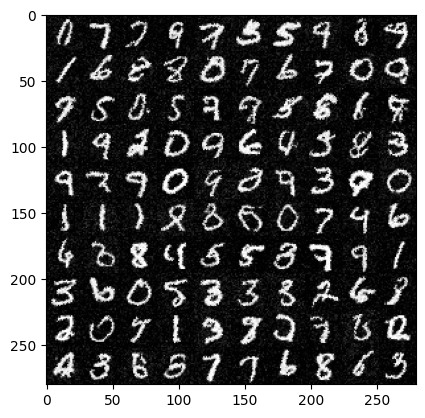

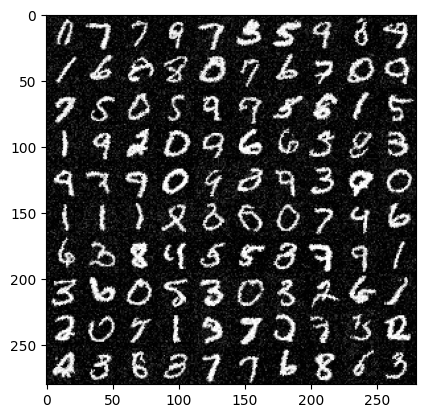

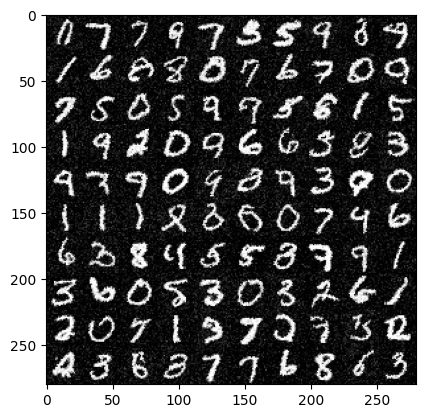

In [ ]:
#Deterministic sampling

generated_images_CFM = torch.zeros([5, 100, 1, 28, 28])

for i, num_steps_solver in enumerate([1,10,100,1000]):


  with torch.no_grad():
    traj = node.trajectory(
          initial_condition,
          t_span=torch.linspace(0, 1, num_steps_solver + 1).to(device),
      )
  grid = make_grid(
      traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
  )
  generated_images_CFM[i, :100] = traj[-1, :100]
  dataname = '/content/drive/MyDrive/cfm_image_data' + str(num_steps_solver) + '.pt'
  torch.save(generated_images_CFM,dataname)
  img = ToPILImage()(grid)
  filename = '/content/drive/MyDrive/' + 'cfm_' + str(num_steps_solver) + '.png'
  img.save(filename)
  plt.figure()
  plt.imshow(img)

In [ ]:
#SDE class

class SDE(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, ode_drift, score, epsilon = 1, input_size=(1, 28, 28), reverse=False):
        super().__init__()
        self.drift = ode_drift
        self.score = score
        self.reverse = reverse
        self.epsilon = epsilon
    # Drift
    def f(self, t, y):
        y = y.view(-1, 1, 28, 28)
        if self.reverse:
            t = 1 - t
            return -self.drift(t, y) + self.score(t, y)
        return self.drift(t, y).flatten(start_dim=1) + self.epsilon * self.score(t, y).flatten(start_dim=1)

    # Diffusion
    def g(self, t, y):
        y = y.view(-1, 1, 28, 28)
        return torch.sqrt(self.epsilon) * (torch.ones_like(t) * torch.ones_like(y)).flatten(start_dim=1) * sigma

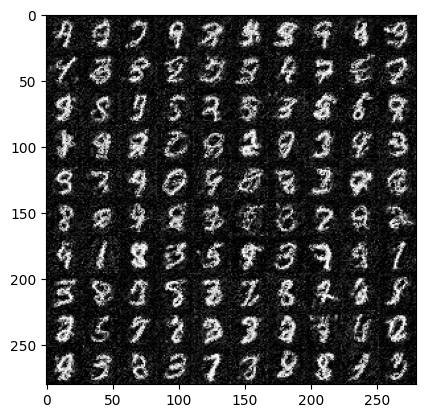

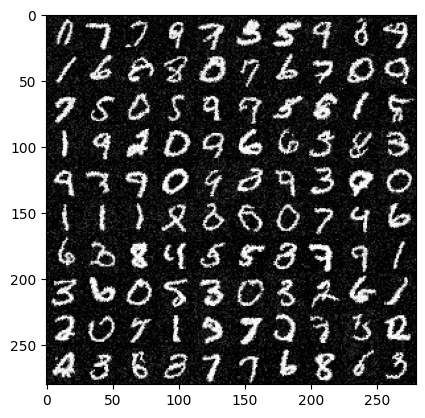

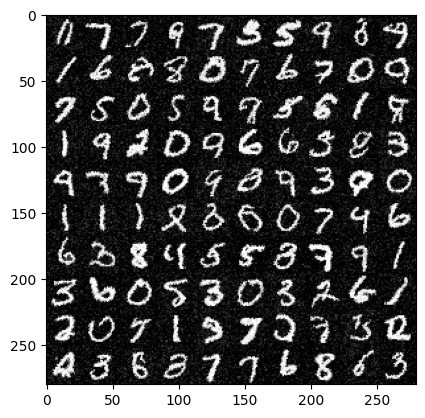

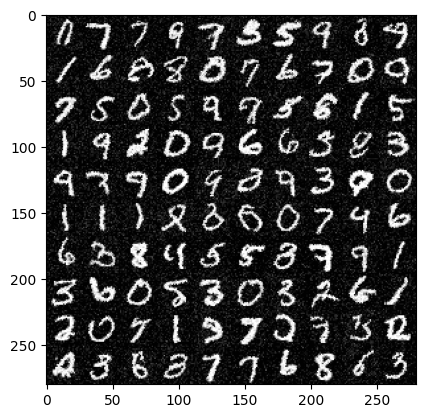

In [ ]:
#Noise = 0.25

noise_coeff = 0.25

generated_images_SDE_1 = torch.zeros([5, 100, 1, 28, 28])
sde = SDE(model, score_model,epsilon = noise_coeff)
for i, num_steps_solver in enumerate([1,10,100,1000]):

  with torch.no_grad():
      sde_traj = torchsde.sdeint(
          sde,
          # x0.view(x0.size(0), -1),
          torch.flatten(initial_condition, start_dim = 1),
          ts=torch.linspace(0, 1, num_steps_solver + 1).to(device),
          dt=1/(num_steps_solver),
      )
  grid = make_grid(
      sde_traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
  )
  generated_images_SDE_1[i, :100] = sde_traj[-1, :100].view([-1, 1, 28, 28])
  dataname = '/content/drive/MyDrive/sde_image_data' + str(num_steps_solver) + '_' + str(noise_coeff) + '.pt'
  torch.save(generated_images_CFM,dataname)
  img = ToPILImage()(grid)
  filename = '/content/drive/MyDrive/' + 'sde_' + str(num_steps_solver) + '_' + str(noise_coeff) + '.png'
  img.save(filename)
  plt.figure()
  plt.imshow(img)

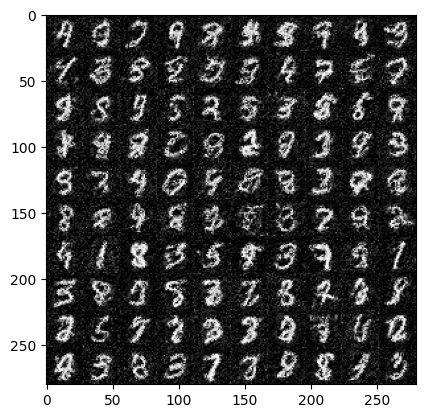

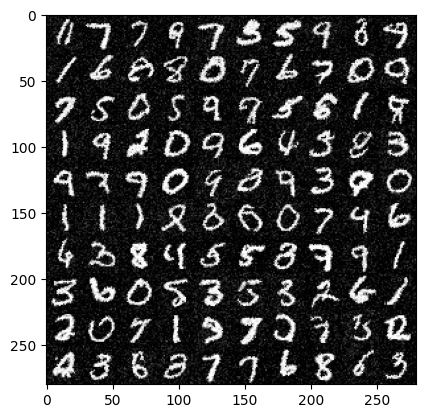

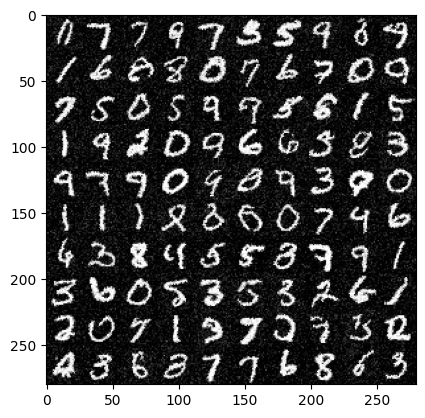

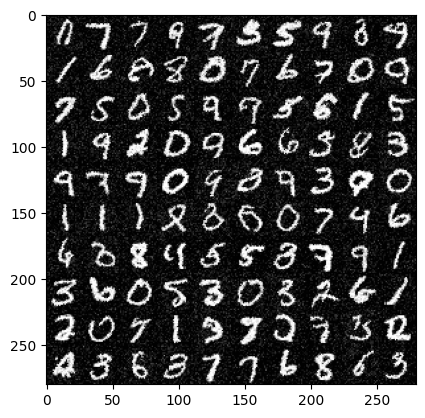

In [ ]:
#Noise = 0.5

noise_coeff = 0.5

generated_images_SDE_2 = torch.zeros([5, 100, 1, 28, 28])
sde = SDE(model, score_model,epsilon = noise_coeff)
for i, num_steps_solver in enumerate([1,10,100,1000]):

  with torch.no_grad():
      sde_traj = torchsde.sdeint(
          sde,
          # x0.view(x0.size(0), -1),
          torch.flatten(initial_condition, start_dim = 1),
          ts=torch.linspace(0, 1, num_steps_solver + 1).to(device),
          dt=1/(num_steps_solver),
      )
  grid = make_grid(
      sde_traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
  )
  generated_images_SDE_2[i, :100] = sde_traj[-1, :100].view([-1, 1, 28, 28])
  dataname = '/content/drive/MyDrive/sde_image_data' + str(num_steps_solver) + '_' + str(noise_coeff) + '.pt'
  torch.save(generated_images_CFM,dataname)
  img = ToPILImage()(grid)
  filename = '/content/drive/MyDrive/' + 'sde_' + str(num_steps_solver) + '_' + str(noise_coeff) + '.png'
  img.save(filename)
  plt.figure()
  plt.imshow(img)

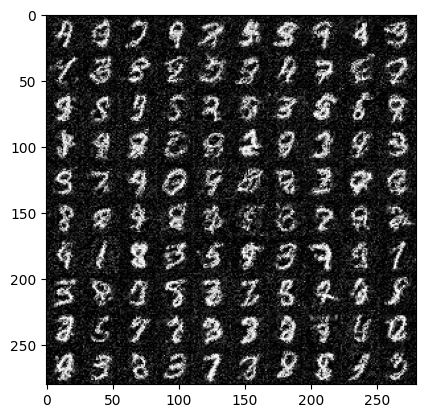

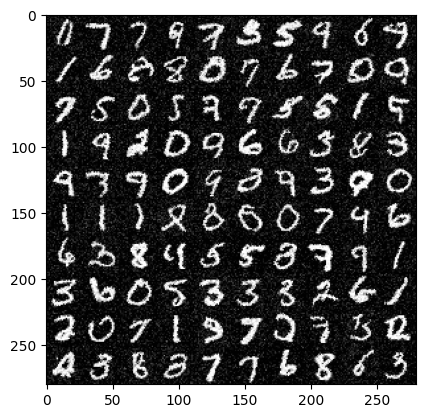

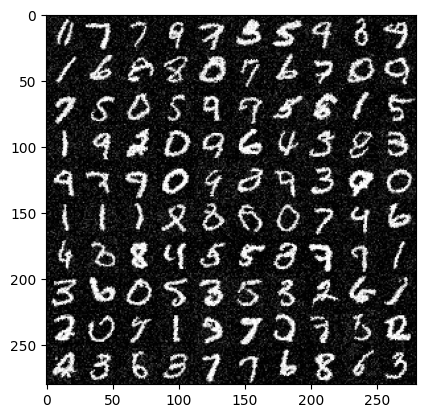

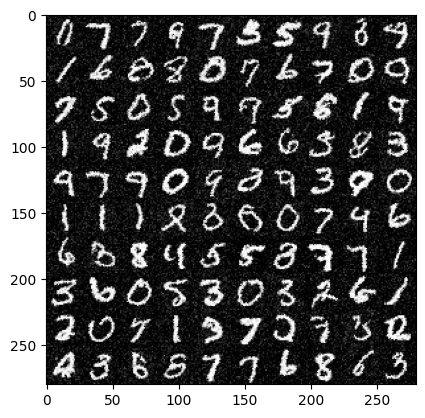

In [ ]:
#Noise = 1

noise_coeff = 1

generated_images_SDE_3 = torch.zeros([5, 100, 1, 28, 28])
sde = SDE(model, score_model,epsilon = noise_coeff)
for i, num_steps_solver in enumerate([1,10,100,1000]):

  with torch.no_grad():
      sde_traj = torchsde.sdeint(
          sde,
          # x0.view(x0.size(0), -1),
          torch.flatten(initial_condition, start_dim = 1),
          ts=torch.linspace(0, 1, num_steps_solver + 1).to(device),
          dt=1/(num_steps_solver),
      )
  grid = make_grid(
      sde_traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
  )
  generated_images_SDE_3[i, :100] = sde_traj[-1, :100].view([-1, 1, 28, 28])
  dataname = '/content/drive/MyDrive/sde_image_data' + str(num_steps_solver) + '_' + str(noise_coeff) + '.pt'
  torch.save(generated_images_CFM,dataname)
  img = ToPILImage()(grid)
  filename = '/content/drive/MyDrive/' + 'sde_' + str(num_steps_solver) + '_' + str(noise_coeff) + '.png'
  img.save(filename)
  plt.figure()
  plt.imshow(img)

In [ ]:
#Noise = 2

noise_coeff = 2

generated_images_SDE_4 = torch.zeros([5, 100, 1, 28, 28])
sde = SDE(model, score_model,epsilon = noise_coeff)
for i, num_steps_solver in enumerate([1,10,100,1000]):

  with torch.no_grad():
      sde_traj = torchsde.sdeint(
          sde,
          # x0.view(x0.size(0), -1),
          torch.flatten(initial_condition, start_dim = 1),
          ts=torch.linspace(0, 1, num_steps_solver + 1).to(device),
          dt=1/(num_steps_solver),
      )
  grid = make_grid(
      sde_traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
  )
  generated_images_SDE_4[i, :100] = sde_traj[-1, :100].view([-1, 1, 28, 28])
  dataname = '/content/drive/MyDrive/sde_image_data' + str(num_steps_solver) + '_' + str(noise_coeff) + '.pt'
  torch.save(generated_images_CFM,dataname)
  img = ToPILImage()(grid)
  filename = '/content/drive/MyDrive/' + 'sde_' + str(num_steps_solver) + '_' + str(noise_coeff) + '.png'
  img.save(filename)
  plt.figure()
  plt.imshow(img)

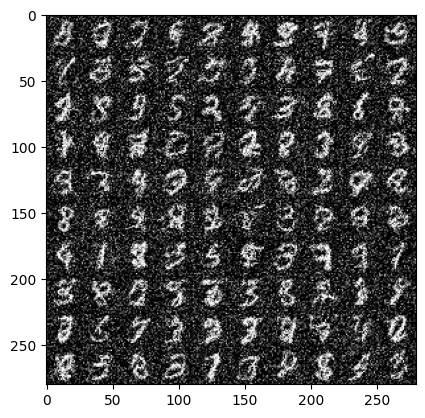

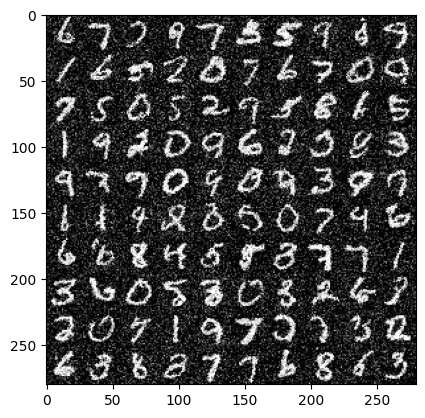

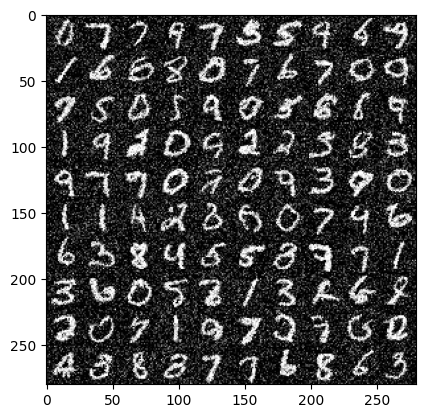

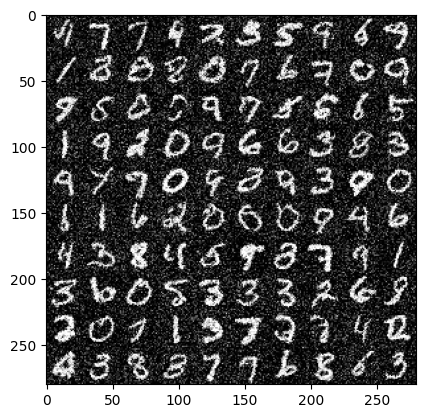

In [ ]:
#Noise = 4

noise_coeff = 4

generated_images_SDE_5 = torch.zeros([5, 100, 1, 28, 28])
sde = SDE(model, score_model,epsilon = noise_coeff)
for i, num_steps_solver in enumerate([1,10,100,1000]):

  with torch.no_grad():
      sde_traj = torchsde.sdeint(
          sde,
          # x0.view(x0.size(0), -1),
          torch.flatten(initial_condition, start_dim = 1),
          ts=torch.linspace(0, 1, num_steps_solver + 1).to(device),
          dt=1/(num_steps_solver),
      )
  grid = make_grid(
      sde_traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
  )
  generated_images_SDE_5[i, :100] = sde_traj[-1, :100].view([-1, 1, 28, 28])
  dataname = '/content/drive/MyDrive/sde_image_data' + str(num_steps_solver) + '_' + str(noise_coeff) + '.pt'
  torch.save(generated_images_CFM,dataname)
  img = ToPILImage()(grid)
  filename = '/content/drive/MyDrive/' + 'sde_' + str(num_steps_solver) + '_' + str(noise_coeff) + '.png'
  img.save(filename)
  plt.figure()
  plt.imshow(img)